# Image Classification using AWS SageMaker

This notebook lists the end-to-end steps to implement an image classification model on AWS SageMaker. The following steps are covered:
- Dataset preparation
- Hyperparameter tuning
- Model training, debugging and profiling
- Model deployment
- Model inference

The trained model is able to classify between different breeds of dogs in images.

In [2]:
#Install relevant packages
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [3]:
#Import relevant packages
import sagemaker
import boto3

## Dataset
This project uses a dog breed classification dataset which contains images from 133 dog breeds divided into training, testing and validation datasets. The dataset is first downloaded from [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) and then uploaded to S3 for model training using SageMaker.

In [4]:
#Download dog breed classication dataset and unzip data (only downloaded once)
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-09-27 10:10:36--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.96
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.5MB/s    in 25s     

2022-09-27 10:11:10 (43.4 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [4]:
session = sagemaker.Session()

bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

prefix = "awsml03"

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-742931343269
AWS Region: us-east-1
RoleArn: arn:aws:iam::742931343269:role/service-role/AmazonSageMaker-ExecutionRole-20220927T164243


In [ ]:
#Upload data to S3 (only uploaded once)
inputs = session.upload_data(path="./dogImages", bucket=bucket, key_prefix=prefix)

In [5]:
#Retrieve S3 data path
import os
inputs = os.path.join("s3://", bucket, prefix)

In [6]:
print("Input spec (in this case, just an S3 path): {}".format(inputs))

Input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-742931343269/awsml03


## Hyperparameter Tuning
This setction finetunes a pretrained model with hyperparameter tuning using the `hpo.py` script.

In [7]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

#Declare HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": IntegerParameter(2, 4)
}

In [10]:
#Create estimators for the HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    #instance_type="ml.m5.xlarge"
    instance_type="ml.p3.2xlarge" #GPU
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

#Create HP tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [11]:
#Fit HP Tuner
os.environ['SM_MODEL_DIR'] = os.path.join("s3://", bucket, prefix, "hpo")
tuner.fit({"training": inputs})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................................................................................................................................................................................................................................!


In [12]:
#Get the best estimator and the best HPs
best_estimator = tuner.best_estimator()
print(f"Best estimator: {best_estimator}")

best_hyperparameters = best_estimator.hyperparameters()
print(f"Best hyperparameters: {best_hyperparameters}")


2022-10-01 11:57:42 Starting - Found matching resource for reuse
2022-10-01 11:57:42 Downloading - Downloading input data
2022-10-01 11:57:42 Training - Training image download completed. Training in progress.
2022-10-01 11:57:42 Uploading - Uploading generated training model
2022-10-01 11:57:42 Completed - Resource reused by training job: pytorch-training-221001-1135-004-69d021b3
Best estimator: <sagemaker.pytorch.estimator.PyTorch object at 0x7f7beb3d3a10>
Best hyperparameters: {'_tuning_objective_metric': '"average test loss"', 'batch-size': '"256"', 'epochs': '3', 'lr': '0.0010526017437543888', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2022-10-01-11-35-38-396"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-11-35-38-3

## Model Profiling and Debugging
This section creates and finetunes a new model using the best hyperparameters.
The `train_model.py` script is used to perform model training, profiling and debugging.

In [13]:
#Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [14]:
from sagemaker.debugger import CollectionConfig, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

# add collection_configs to record losses
collection_configs = CollectionConfig(name="CrossEntropyLoss_output_0",
                                     parameters={"include_regex": "CrossEntropyLoss_output_0", 
                                                 "train.save_interval": "10",
                                                 "eval.save_interval": "1"})

debugger_config = DebuggerHookConfig(
    collection_configs=[collection_configs],
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [15]:
#Create and fit an estimator using the best HPs
hyperparameters = {
    "lr": 0.00105260174375438,
    "batch-size": 256,
    "epochs": 3
}

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge", #GPU
    #instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [16]:
# Fit the estimator
os.environ['SM_MODEL_DIR'] = os.path.join("s3://", bucket, prefix, "debugging-profiling")
estimator.fit({"training": inputs}, wait=True)

2022-10-01 12:12:03 Starting - Starting the training job...
2022-10-01 12:12:32 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-10-01 12:13:58 Downloading - Downloading input data.........
2022-10-01 12:15:34 Training - Downloading the training image.....................
2022-10-01 12:19:00 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-01 12:18:48,511 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-01 12:18:48,545 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-01 12:18:48,554 sagemaker_pytorch_container.training INFO     Invoking user trai

In [17]:
#Plot a debugging output.
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-10-01-12-12-03-254
Region: us-east-1


In [18]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

#Print the names of all the tensors that were tracked
print(trial.tensor_names())

#Print the number of datapoints for one of those tensors for both train and eval mode
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-10-01 12:26:16.668 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-01 12:26:16.697 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-12-12-03-254/debug-output
[2022-10-01 12:26:17.464 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-10-01 12:26:18.483 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', '

In [19]:
# Set up functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


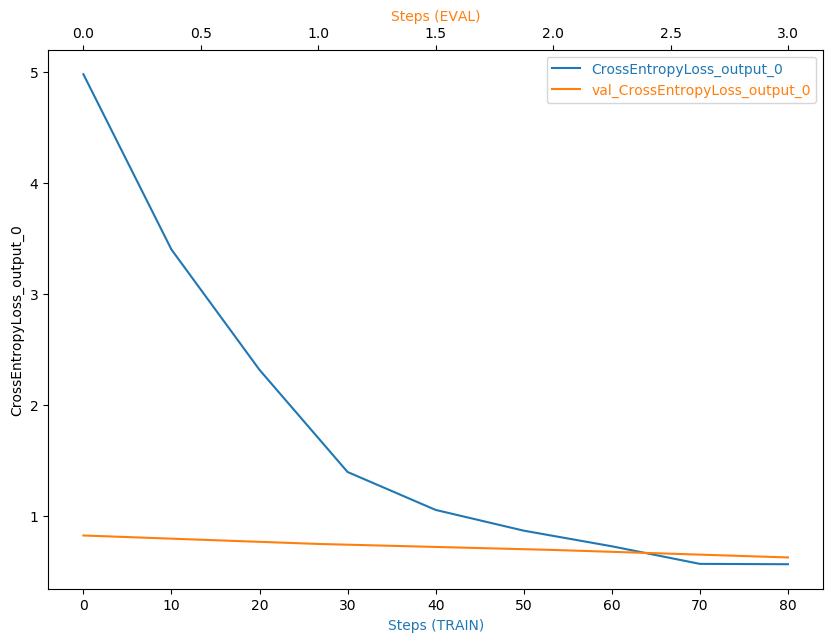

In [21]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

There is no obvious anomalous behaviour in the debugging output. However, there was LowGPUUtilization which indicated that a smaller instance type could be chosen instead.
If there were LossNotDecreasing issue, I would implement an early stopping logic to stop training when certain loss threshold was achieved.

In [22]:
#Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print (rule_output_path)

s3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-12-12-03-254/rule-output


In [24]:
! aws s3 ls {rule_output_path} --recursive

2022-10-01 12:25:20     442091 pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-01 12:25:20     302763 pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-01 12:25:14        568 pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-01 12:25:15      29142 pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-01 12:25:15       2494 pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-01 12:25:15        325 pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-01 12:25:15      12911 pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-re

In [25]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-12-12-03-254/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-12-12-03-254/rule-outp

In [26]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [27]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [47]:
#Deploy the model to an endpoint after training
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.p2.xlarge")

-----------!

In [72]:
#An alternative approach to load and deploy saved model using inference.py
from sagemaker.pytorch.model import PyTorchModel

model_path = 's3://sagemaker-us-east-1-742931343269/pytorch-training-2022-10-01-12-12-03-254/output/model.tar.gz'

estimator = PyTorchModel(model_data=model_path,
                         role=role,
                         entry_point='inference.py',
                         py_version='py36',
                         framework_version='1.8')

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.p2.xlarge")

-------------!

In [76]:
#Run inference on below sample images

images = {'./dogImages/test/012.Australian_shepherd/Australian_shepherd_00868.jpg':'12',
          './dogImages/test/054.Collie/Collie_03834.jpg':'54'
         }

The dog image used for classification is ./dogImages/test/012.Australian_shepherd/Australian_shepherd_00868.jpg:


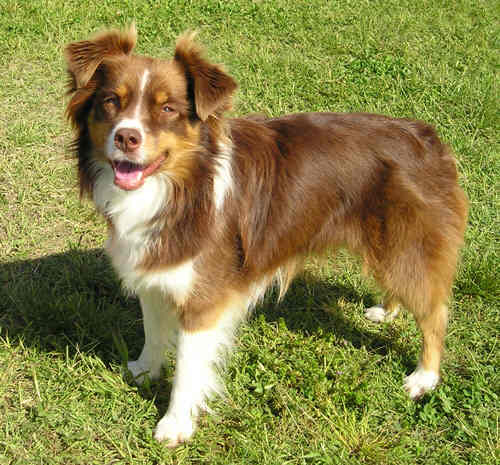


The predicted dog breed lable is 12
The actual dog breed lable is 12

Raw prediction result:
[[-6.46844864 -4.63818359 -5.62925959 -3.08068538 -3.6331346  -3.98994255
  -5.04442453 -5.41035271 -6.09590626 -4.14711332 -4.30361748  1.45700097
  -3.54908967 -4.18061972 -5.58907318 -4.40122271 -3.54174423 -5.32594967
  -5.64279175 -7.06047201 -4.57002497 -3.59296799 -2.92632675 -6.35684681
  -7.27847624 -7.37222433 -7.84267616 -6.79285622  1.29527032 -5.21563387
  -4.2304287  -4.94935226 -7.26631355 -6.09560728 -4.49325514 -5.83249664
  -2.6645534  -3.51254749 -5.46291494 -5.8488307  -6.92005205 -5.09242487
  -4.13191986 -6.81540871 -2.65806651 -2.92547226 -5.66161394 -4.08591223
  -4.56599188 -6.49721622 -4.49685431 -4.38966894 -4.94268227 -0.37569991
  -6.14801788 -3.17161608 -6.0722127  -6.41484499 -5.73919678 -5.38162231
  -4.51253271 -5.10431433 -2.08731818 -4.09581327 -4.05567408 -5.69448471
  -4.26686049 -3.4791491  -6.15016937 -5.33856535 -4.20071316 -5.98611546
  -5.71414804 -5.5

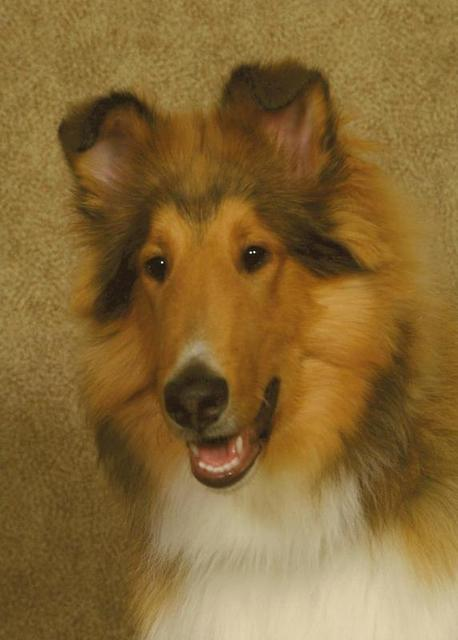


The predicted dog breed lable is 54
The actual dog breed lable is 54

Raw prediction result:
[[-7.11680984 -2.02611494 -4.27739477 -3.1208384  -3.87598348 -3.63634896
  -4.40908098 -6.34733963 -6.7779355  -5.18732834 -3.90505767  1.5949074
  -2.26614928 -3.04545403 -4.43583775 -5.53868246 -2.73802614 -4.52323151
  -5.4704833  -6.56063128 -2.590662   -1.07666373 -4.0006094  -7.24730015
  -6.0212121  -7.05196667 -5.67409182 -5.78202152  0.24805139 -6.79818201
  -1.95296299 -6.70556355 -6.29858065 -7.53735018 -5.60668659 -4.55725718
  -4.93124247 -4.29871988 -5.33794022 -6.63646364 -7.54038334 -4.55172348
  -3.96569777 -7.60042524 -3.25468326 -5.57682991 -5.77075243 -6.19591141
  -4.24459124 -5.24310064 -3.40449953 -5.09791994 -5.04278421  5.52886248
  -6.62070036 -2.4452827  -6.18813992 -7.59633589 -4.75725222 -6.08253288
  -3.19248223 -4.56982756 -4.46548033 -5.72343493 -6.54510355 -6.49217796
  -2.23180318 -3.87201309 -7.38780022 -3.97841144 -3.58651567 -7.08593988
  -6.40963078 -4.80

In [77]:
#Run inference and display results
import io
from PIL import Image

for image, label in images.items():
    #Display image to be predicted
    print(f'The dog image used for classification is {image}:')
    display(Image.open(image))
    
    #Inference
    image_bytes = io.BytesIO(open(image, 'rb').read())
    response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})

    prediction = np.argmax(response[0]) + 1
    print(f'\nThe predicted dog breed lable is {prediction}')
    print(f'The actual dog breed lable is {label}\n')
    
    print("Raw prediction result:")
    print(response)
    print()

    labeled_predictions = list(zip(range(1,134,1), response[0]))
    print("Labeled predictions: ")
    print(labeled_predictions)
    print()
    
    labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
    print(f"Most likely answer: {labeled_predictions[0]}\n")

In [78]:
#Delete the endpoint after use
predictor.delete_endpoint()